## Imports

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


pd.options.display.float_format = '{:.2f}'.format # change the +e format to number


# Dataset 1

## Data Exploration And Cleaning

In [ ]:
# Importing the data
df_dataset1 = pd.read_excel("Dataset 1 Final.xlsx")


In [ ]:
df_dataset1.head()

,Retailer ID,Order Id,Created,Delivered,Order Status,Region,Sales,Discount Amount,Channel
0,67.00,6285132,2024-01-06,2024-01-09,Delivered,Greater Cairo,1648.50,0.00,telesales
1,67.00,6303054,2024-01-09,2024-01-11,Delivered,Greater Cairo,5475.75,86.30,telesales
2,67.00,6314278,2024-01-11,2024-01-16,Delivered,Greater Cairo,1452.15,0.00,telesales
3,67.00,6320349,2024-01-12,2024-01-15,Delivered,Greater Cairo,2401.70,0.00,telesales
4,67.00,6347716,2024-01-16,2024-01-21,Delivered,Greater Cairo,3289.47,288.07,telesales


In [ ]:
df_dataset1.info()
# there is some null value in retailer ID and delivered comlumns need further analysis
# one of the analysis to be done is to check if all null values of the delivered with status failed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472253 entries, 0 to 472252
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Retailer ID      472035 non-null  float64       
 1   Order Id         472253 non-null  int64         
 2   Created          472253 non-null  datetime64[ns]
 3   Delivered        420965 non-null  datetime64[ns]
 4   Order Status     472253 non-null  object        
 5   Region           472253 non-null  object        
 6   Sales            472253 non-null  float64       
 7   Discount Amount  472253 non-null  float64       
 8   Channel          472253 non-null  object        
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 32.4+ MB


### Check The Uniques Values

In [ ]:
for col in ["Retailer ID", "Order Status", "Region","Channel"]:
    unique_values = df_dataset1[col].nunique()
    print(f"{col}: {unique_values} unique values")


for col in ["Region", "Order Status", "Channel"]:
    print(f"{col}: {df_dataset1[col].unique()}")

# Status is only Delivered or failed, so either the order still not delivered is shown as failed, or the dataset contains only devilvered and failed orders
# we need to see if there is coorelation between regions and channel

Retailer ID: 70909 unique values
Order Status: 2 unique values
Region: 3 unique values
Channel: 6 unique values
Region: ['Greater Cairo' 'Alexandria' 'Upper Egypt']
Order Status: ['Delivered' 'Failed']
Channel: ['telesales' 'agent' 'admin' 'retailer' 'sales agent' 'cartona']


### Check Null Values

In [ ]:
print(f"Retailer ID containing null values: {df_dataset1['Retailer ID'].isnull().sum()}")
print(f"Delivered containing null values: {df_dataset1['Delivered'].isnull().sum()}")

Retailer ID containing null values: 218
Delivered containing null values: 51288


In [ ]:
# Filter rows where 'Delivered' is null
null_delivered = df_dataset1[df_dataset1['Delivered'].isnull()]

# Count the number of rows where 'Order Status' is 'Failed'
failed_count = null_delivered[null_delivered['Order Status'] == 'Failed'].shape[0]
delivered_count = null_delivered[null_delivered['Order Status'] == 'Delivered'].shape[0]

print(f"There are {failed_count} rows where 'Delivered' is null and 'Order Status' is 'Failed'.")
print(f"There are {delivered_count} rows where 'Delivered' is null and 'Order Status' is 'delivered_count'.")
# There are 204 rows where 'Delivered' is null and 'Order Status' is 'successed', delivery date may sill not updated -> need to check with the stackholders


There are 51084 rows where 'Delivered' is null and 'Order Status' is 'Failed'.
There are 204 rows where 'Delivered' is null and 'Order Status' is 'delivered_count'.


Some assumption I took
- There is 204 orders that does not contain delivered date, however it is successed, I assume that delivery data still not updated

### Check Duplicates

In [ ]:
# Check if there is duplicated in the orders
duplicates = df_dataset1[df_dataset1.duplicated('Order Id')]
duplicate_counts = df_dataset1['Order Id'].value_counts()
duplicate_counts
filtered_df = df_dataset1[df_dataset1['Order Id'] == 6253912]
print(filtered_df) # making sure that the duplicates are alike
df_dataset1.drop_duplicates(subset=['Order Id'], keep='first', inplace=True)


        Retailer ID  Order Id    Created  Delivered Order Status  \
9127        7237.00   6253912 2024-01-01 2024-01-03    Delivered   
472250      7237.00   6253912 2024-01-01 2024-01-03    Delivered   

               Region   Sales  Discount Amount   Channel  
9127    Greater Cairo 1365.35             0.00  retailer  
472250  Greater Cairo 1365.35             0.00  retailer  


### Check Outliers

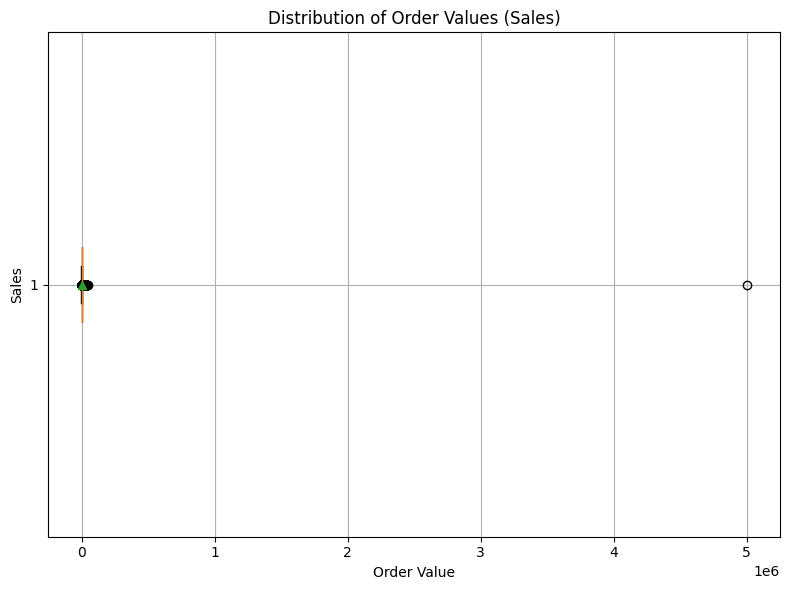

In [ ]:
# Create a box plot for 'Sales' column
plt.figure(figsize=(8, 6))
plt.boxplot(df_dataset1['Sales'], vert=False, patch_artist=True, showmeans=True)
plt.title('Distribution of Order Values (Sales)')
plt.xlabel('Order Value')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
Q1 = df_dataset1['Sales'].quantile(0.25)
Q3 = df_dataset1['Sales'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_dataset1[(df_dataset1['Sales'] < Q1 - 1.5 * IQR) | (df_dataset1['Sales'] > Q3 + 1.5 * IQR)]

In [ ]:
# outliers maybe useful
# df_dataset1 = df_dataset1[(df_dataset1['Sales'] >= Q1 - 1.5 * IQR) & (df_dataset1['Sales'] <= Q3 + 1.5 * IQR)]

## Performance KPIs

#### Create Regions DataFrames

In [ ]:
greater_cairo_region_df = df_dataset1[df_dataset1['Region'] == "Greater Cairo"]
alex_region_df = df_dataset1[df_dataset1['Region'] == "Alexandria"]
upper_egypt_region_df = df_dataset1[df_dataset1['Region'] == "Upper Egypt"]

#### Helper Functions

In [ ]:
def get_monthly_KPIs(region_df):
    region_df['YearMonth'] = region_df['Created'].dt.to_period('M')
    monthly_sales = region_df.groupby('YearMonth')['Sales'].sum()
    monthly_orders = region_df.groupby('YearMonth')['Order Id'].sum()
    monthly_retailers = region_df.groupby('YearMonth')['Retailer ID'].nunique()
    monthly_aov = region_df.groupby('YearMonth')['Sales'].mean()
    retailer_orders_per_month = region_df.groupby(['Retailer ID', 'YearMonth'])['Order Id'].sum().reset_index()
    return monthly_sales, monthly_orders, monthly_retailers, monthly_aov, retailer_orders_per_month

In [ ]:
def plot_retailer_orders_per_month(retailer_orders_per_month):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=retailer_orders_per_month, x='YearMonth', y='Order Id', hue='Retailer ID')
    ax.set_title('Average Orders per Retailer per Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Orders')
    plt.xticks(rotation=45)
    plt.legend(title='Retailer ID', bbox_to_anchor=(1, 1), loc='upper left')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_monthly_analysis(monthly_sales, monthly_orders, monthly_retailers, monthly_aov):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', linestyle='-')
    axs[0, 0].set_title('Monthly Sales')
    axs[0, 0].set_xlabel('Month')
    axs[0, 0].set_ylabel('Total Sales')
    axs[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
    axs[0, 1].plot(monthly_orders.index.astype(str), monthly_orders.values, marker='o', linestyle='-')
    axs[0, 1].set_title('Monthly Orders')
    axs[0, 1].set_xlabel('Month')
    axs[0, 1].set_ylabel('Total Orders')
    axs[0, 1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
    axs[1, 0].plot(monthly_retailers.index.astype(str), monthly_retailers.values, marker='o', linestyle='-')
    axs[1, 0].set_title('Monthly Unique Retailers')
    axs[1, 0].set_xlabel('Month')
    axs[1, 0].set_ylabel('Number of Retailers')
    axs[1, 1].plot(monthly_aov.index.astype(str), monthly_aov.values, marker='o', linestyle='-')
    axs[1, 1].set_title('Average Order Value (AOV)')
    axs[1, 1].set_xlabel('Month')
    axs[1, 1].set_ylabel('AOV')
    plt.tight_layout()
    plt.show()


#### Greater Cairo Analysis

In [ ]:
cairo_monthly_sales, cairo_monthly_orders, cairo_monthly_retailers, cairo_monthly_aov, cairo_retailer_orders_per_month = get_monthly_KPIs(greater_cairo_region_df)
print(cairo_monthly_orders.head())

YearMonth
2024-01    507589381900
2024-02    492698738079
2024-03    449627064768
2024-04    379266442157
2024-05    239264576699
Freq: M, Name: Order Id, dtype: int64


/var/folders/cl/z_v777rd4mndgt2ypckwzb_m0000gn/T/ipykernel_3431/4278834090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['YearMonth'] = region_df['Created'].dt.to_period('M')


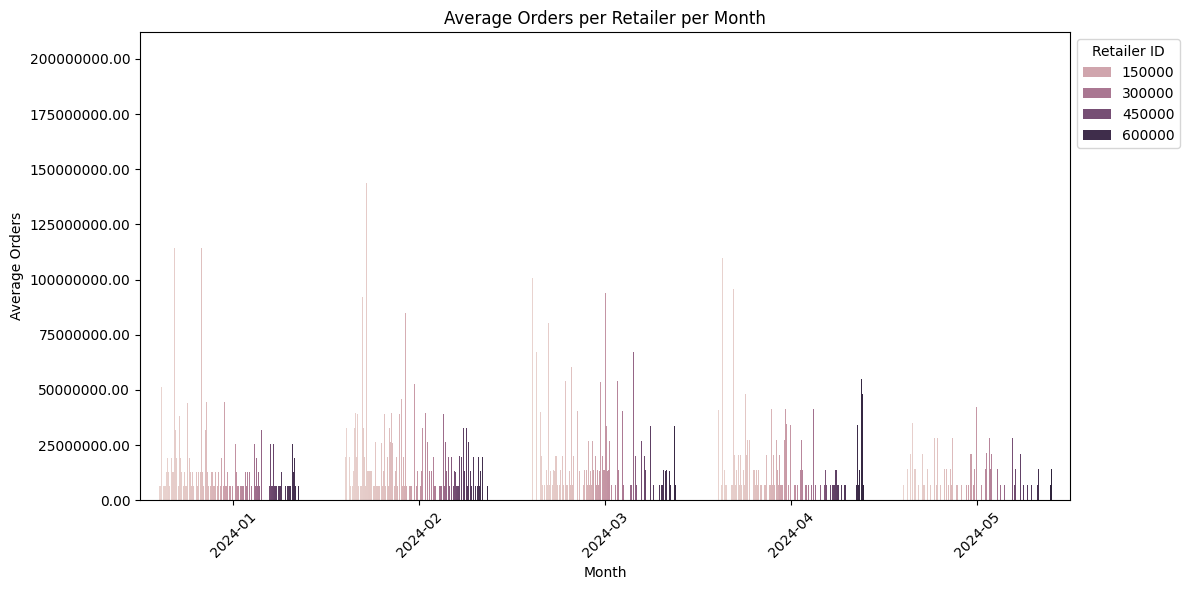

In [ ]:
plot_retailer_orders_per_month(cairo_retailer_orders_per_month)

*Conclusion from above diagram* : Some retailers' average orders decrease significantly  

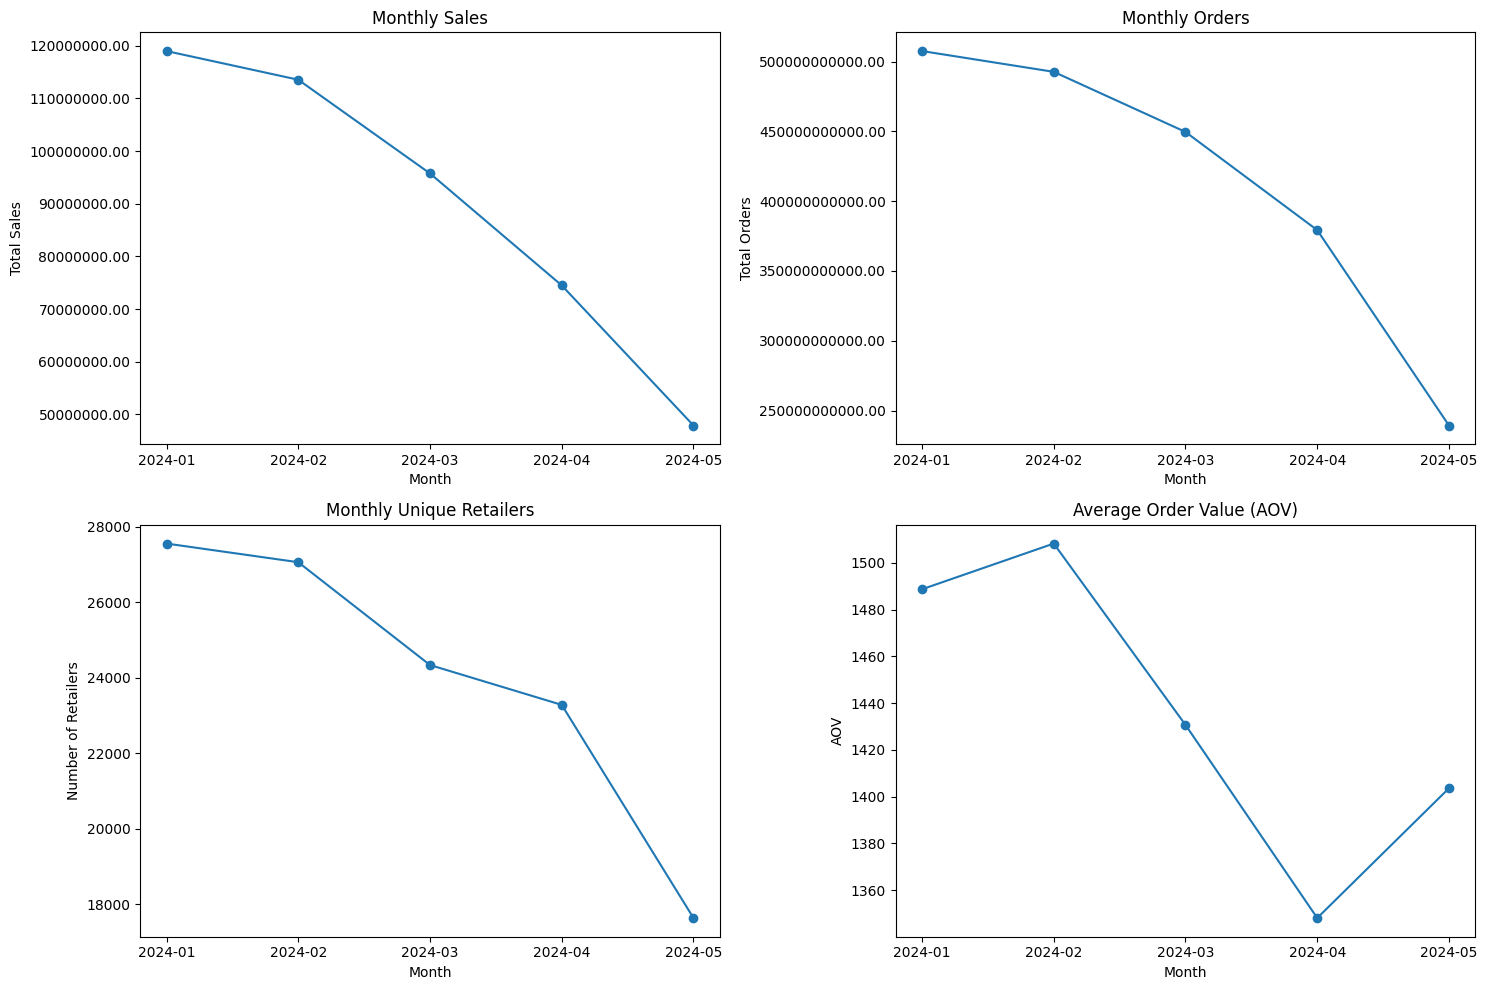

In [ ]:
plot_monthly_analysis(cairo_monthly_sales, cairo_monthly_orders, cairo_monthly_retailers, cairo_monthly_aov)

#### Alexandria Analysis

In [ ]:
alex_monthly_sales, alex_monthly_orders, alex_monthly_retailers, alex_monthly_aov, alex_retailer_orders_per_month = get_monthly_KPIs(alex_region_df)
print(alex_monthly_orders.head())

YearMonth
2024-01    54213243758
2024-02    61748832971
2024-03    67897266235
2024-04    59034078734
2024-05    41537010394
Freq: M, Name: Order Id, dtype: int64


/var/folders/cl/z_v777rd4mndgt2ypckwzb_m0000gn/T/ipykernel_3431/4278834090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['YearMonth'] = region_df['Created'].dt.to_period('M')


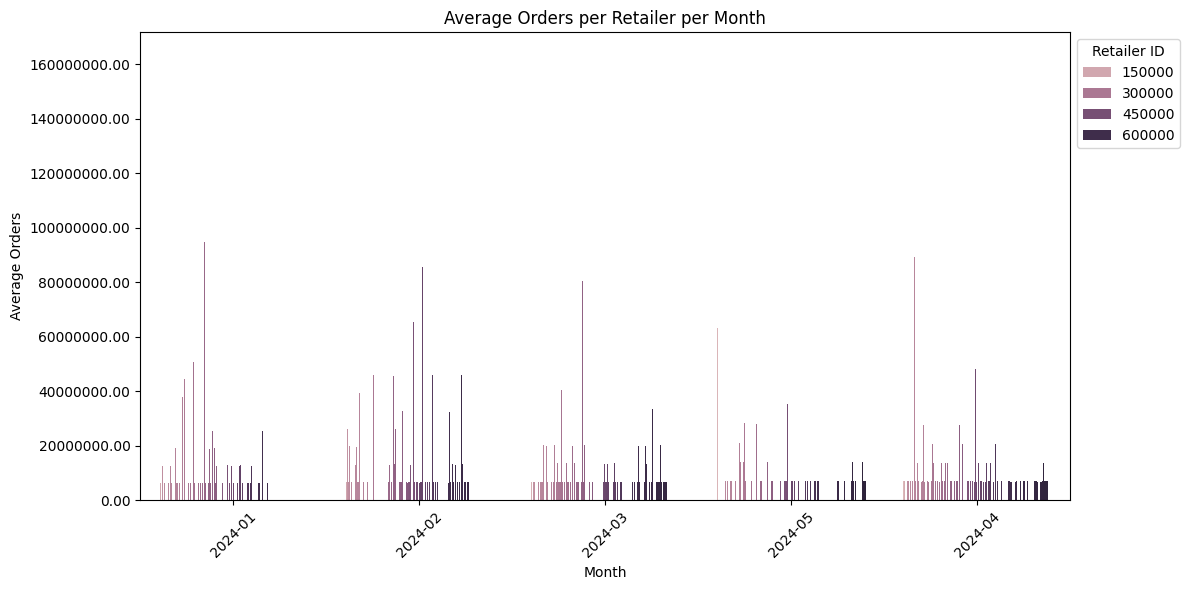

In [ ]:
plot_retailer_orders_per_month(alex_retailer_orders_per_month)

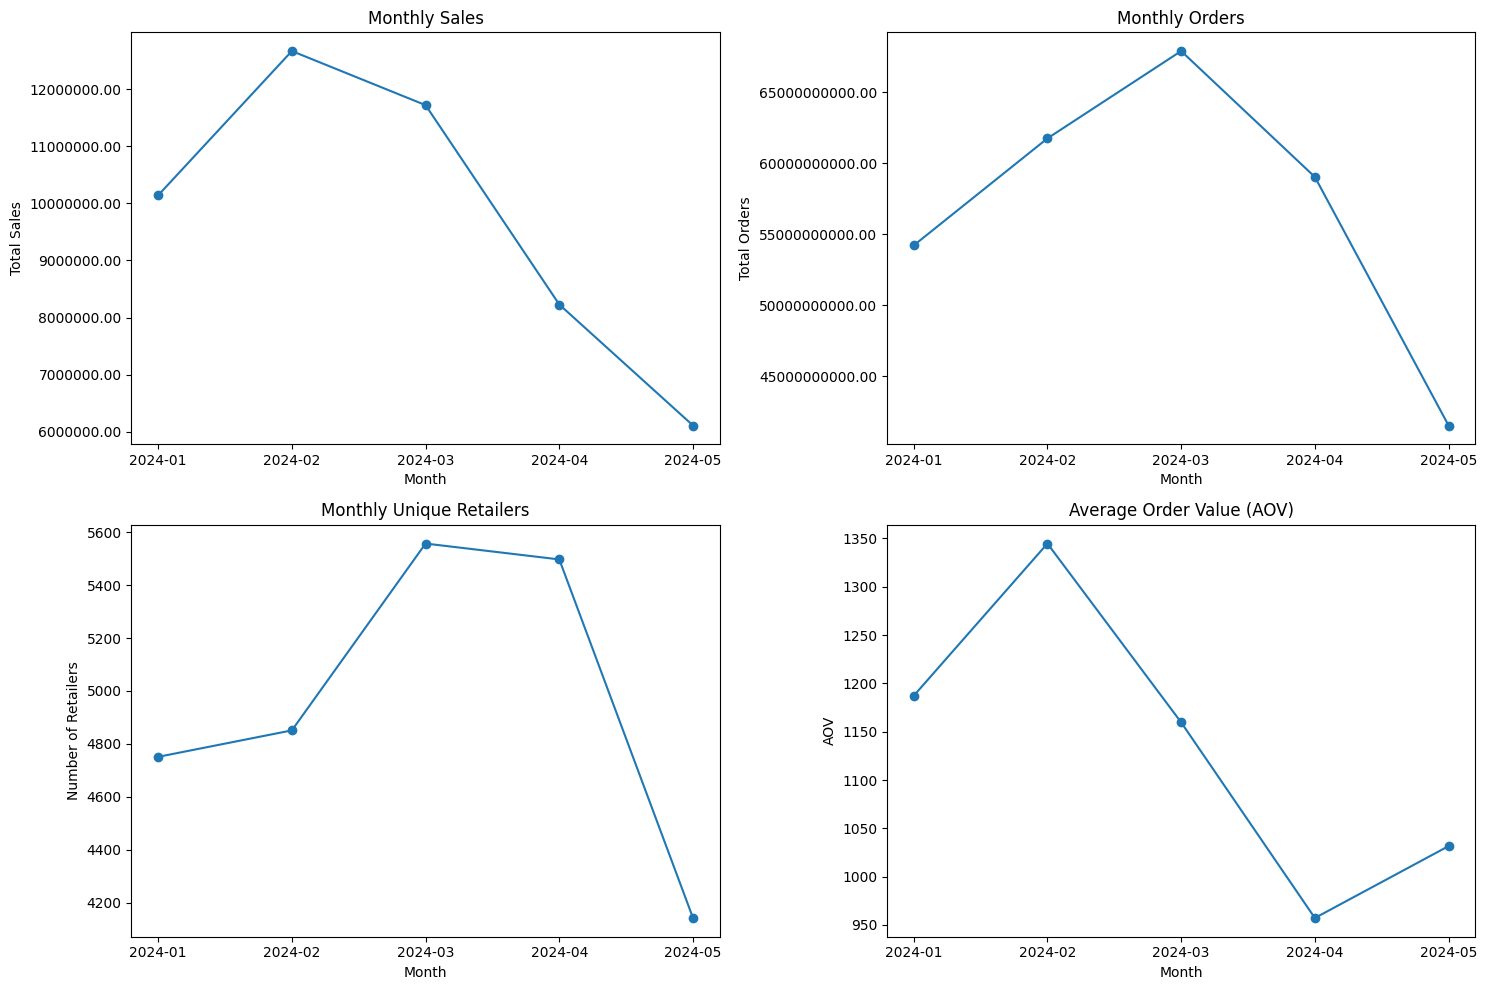

In [ ]:
plot_monthly_analysis(alex_monthly_sales, alex_monthly_orders, alex_monthly_retailers, alex_monthly_aov)

#### Upper Egypt Analysis

In [ ]:
upper_e_monthly_sales, upper_e_monthly_orders, upper_e_monthly_retailers, upper_e_monthly_aov, upper_e_retailer_orders_per_month = get_monthly_KPIs(upper_egypt_region_df)
print(upper_e_monthly_orders.head())

YearMonth
2024-01    133904782237
2024-02    127350750177
2024-03    103764173921
2024-04     88351778528
2024-05     59388822398
Freq: M, Name: Order Id, dtype: int64


/var/folders/cl/z_v777rd4mndgt2ypckwzb_m0000gn/T/ipykernel_3431/4278834090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['YearMonth'] = region_df['Created'].dt.to_period('M')


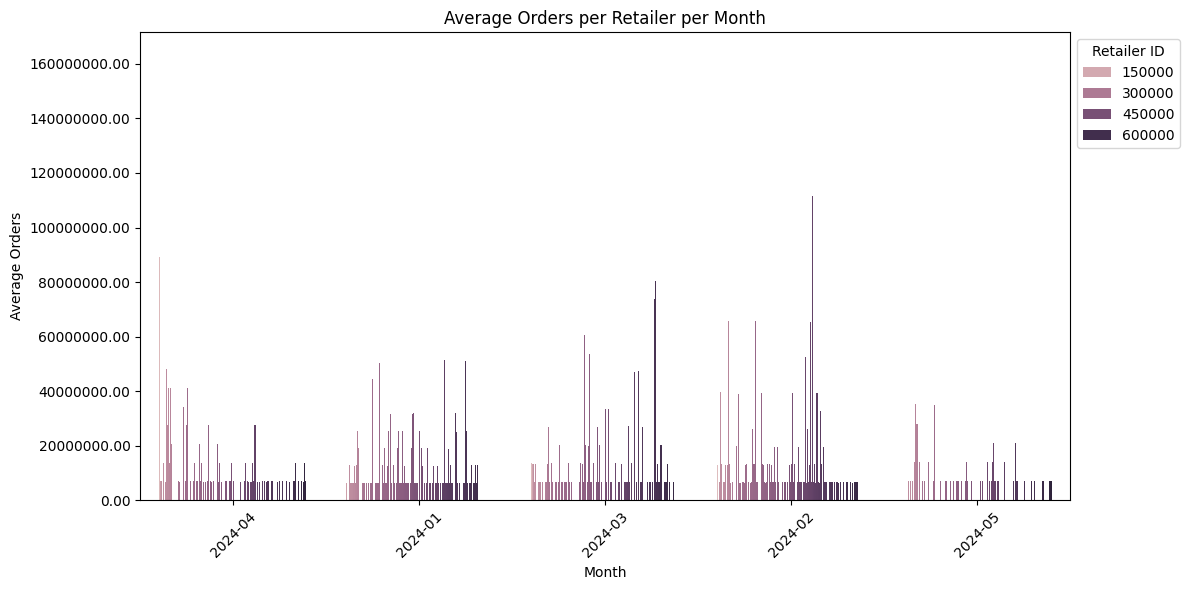

In [ ]:
plot_retailer_orders_per_month(upper_e_retailer_orders_per_month)

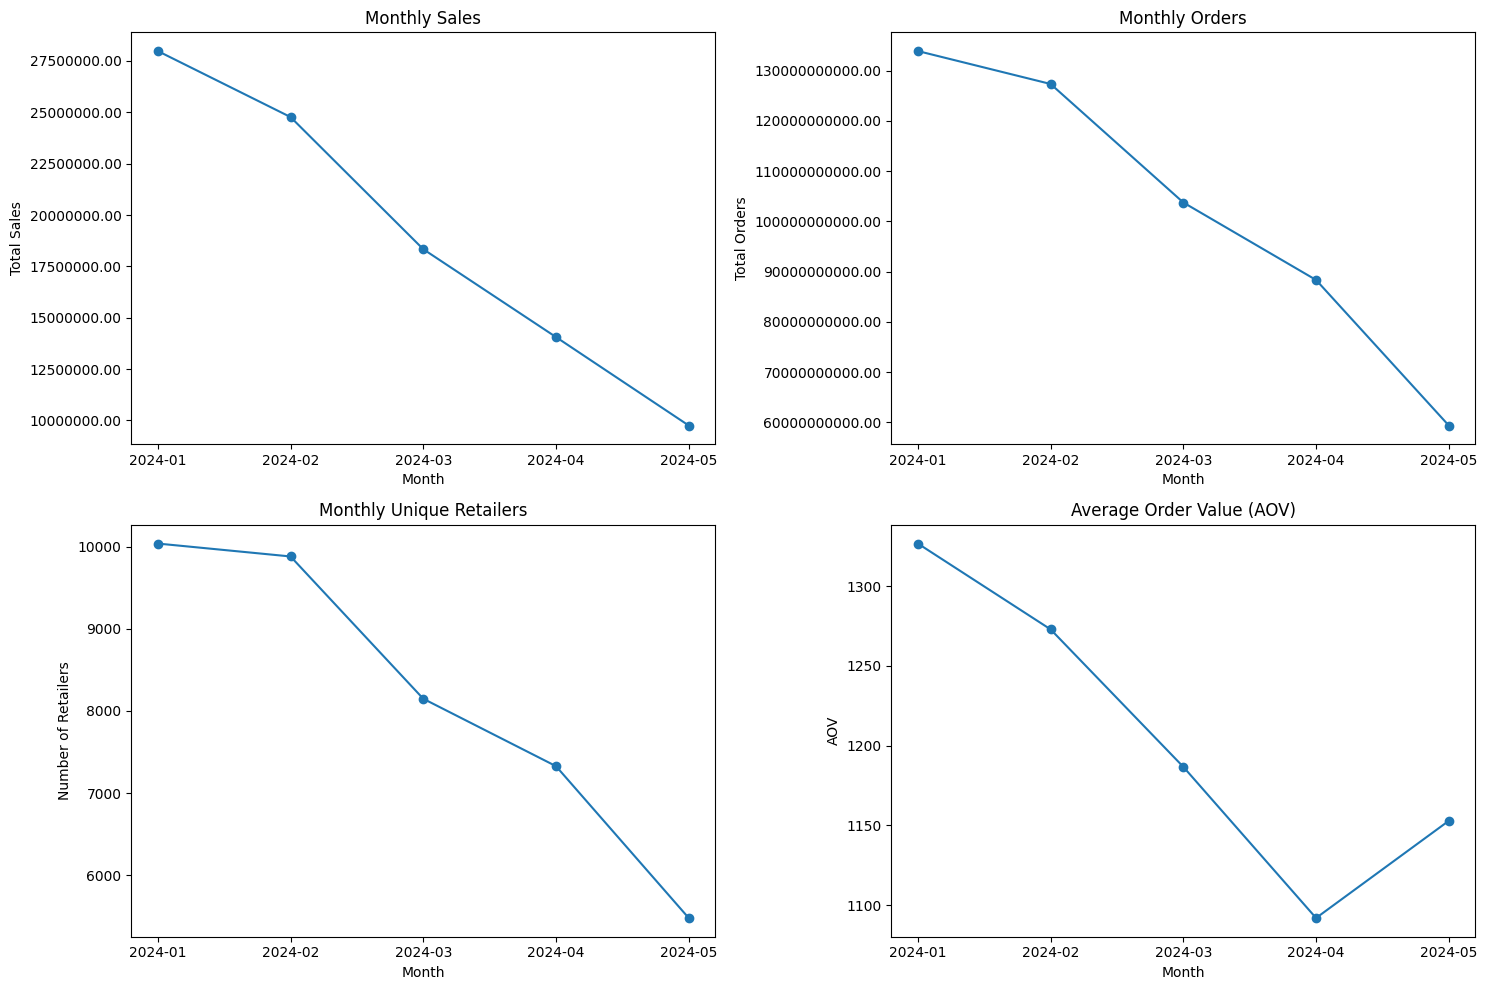

In [ ]:
plot_monthly_analysis(upper_e_monthly_sales, upper_e_monthly_orders, upper_e_monthly_retailers, upper_e_monthly_aov)

#### Conclusion

*Conclusion* : Sales Starting dropping when the average order value decreased on March 2024 and the number of retailers decreased as well causing the total sales to decrease
The retailers which decrease maybe that ones that was ordering with high value, however this needs further analysis

## Data Activation

In [ ]:
df_dataset1['Created'] = pd.to_datetime(df_dataset1['Created'])
df_dataset1['Activation Date'] = df_dataset1.groupby([df_dataset1['Created'].dt.year, df_dataset1['Created'].dt.month, 'Retailer ID'])['Created'].transform('min')
march_april_df = df_dataset1[(df_dataset1['Created'].dt.month == 3) | (df_dataset1['Created'].dt.month == 4)]
daily_activation = march_april_df.groupby([march_april_df['Created'].dt.date])['Retailer ID'].nunique().reset_index()
daily_activation.columns = ['Date', 'Activation Count']
print("Daily Activation in March and April:")
print(daily_activation) # noticed that the timeframe is from 1/3/24 to 30/4/24


Daily Activation in March and April:
          Date  Activation Count
0   2024-03-01              2196
1   2024-03-02              3636
2   2024-03-03              3697
3   2024-03-04              3970
4   2024-03-05              3681
..         ...               ...
56  2024-04-26              1449
57  2024-04-27              2637
58  2024-04-28              2842
59  2024-04-29              3016
60  2024-04-30              3438

[61 rows x 2 columns]


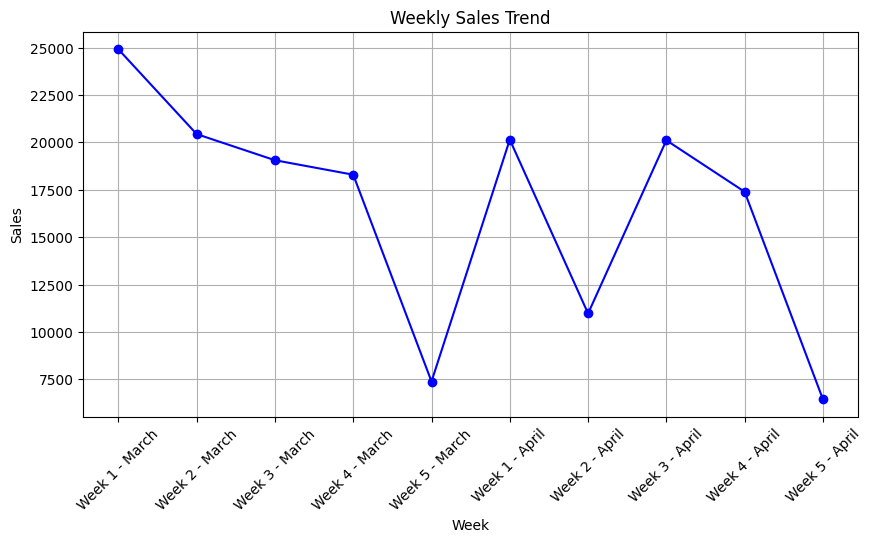

             Week  Activation Count
0  Week 1 - March             24906
1  Week 2 - March             20436
2  Week 3 - March             19058
3  Week 4 - March             18295
4  Week 5 - March              7392
5  Week 1 - April             20144
6  Week 2 - April             10979
7  Week 3 - April             20109
8  Week 4 - April             17395
9  Week 5 - April              6454
Week 1 - March has the highest activation with 24906 activations.


In [ ]:
daily_activation['Date'] = pd.to_datetime(daily_activation['Date'])

# Month_Num and Week_Num is created to be used for ordering of the data
# Month and Week is used to be visualing appealing instead of the year week
daily_activation['Month'] = daily_activation['Date'].dt.month_name()
daily_activation['Month_Num'] = daily_activation['Date'].dt.month
daily_activation['Week_Num'] = daily_activation['Date'].apply(lambda x: (x.day - 1) // 7 + 1)
daily_activation['Week'] = daily_activation.apply(lambda x: f"Week {x['Week_Num']} - {x['Month']}", axis=1)
weekly_activation = daily_activation.groupby(['Month_Num', 'Week_Num', 'Week'])['Activation Count'].sum().reset_index()

weekly_activation.sort_values(by=['Month_Num', 'Week_Num'], inplace=True)

# Fetch the week with the highest activation
week_with_highest_activation = weekly_activation.loc[weekly_activation['Activation Count'].idxmax()]

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(weekly_activation["Week"], weekly_activation["Activation Count"], marker='o', linestyle='-', color='b')
plt.title('Weekly Sales Trend')
plt.xlabel('Week')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.grid(True)
plt.show()

print(weekly_activation[['Week', 'Activation Count']])
print(f"{week_with_highest_activation['Week']} has the highest activation with {week_with_highest_activation['Activation Count']} activations.")


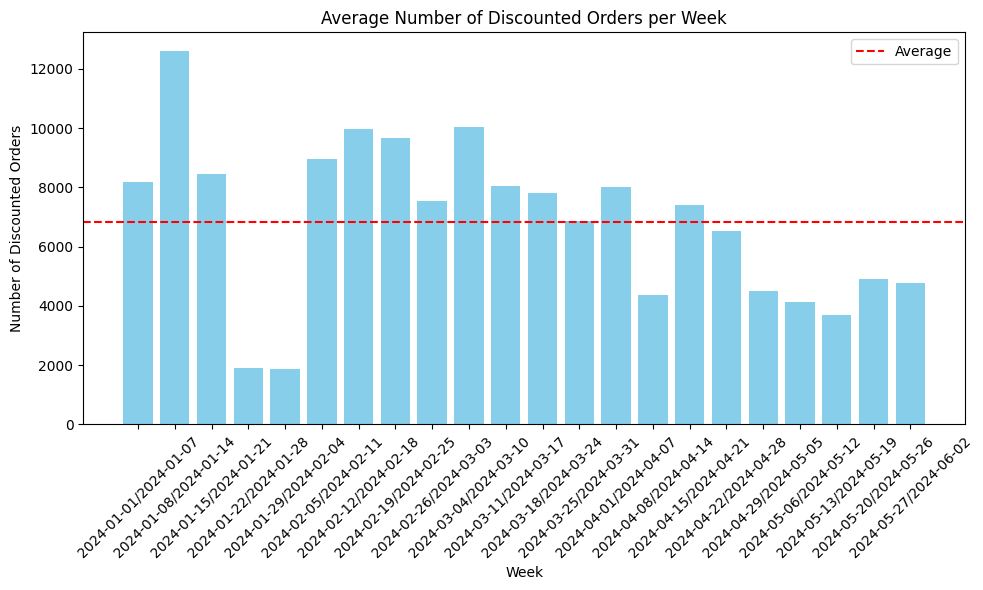

In [ ]:
df_dataset1['Created'] = pd.to_datetime(df_dataset1['Created'])

# Extract week from 'Created' column
df_dataset1['Week'] = df_dataset1['Created'].dt.to_period('W')

# Identify orders with discounts
df_dataset1['Has Discount'] = df_dataset1['Discount Amount'] > 0

# Group by week and count the number of discounted orders
weekly_discounted_orders = df_dataset1[df_dataset1['Has Discount']].groupby('Week')['Order Id'].count().reset_index(name='Count')

# Calculate the average number of discounted orders per week
average_discounted_orders = weekly_discounted_orders['Count'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(weekly_discounted_orders['Week'].astype(str), weekly_discounted_orders['Count'], color='skyblue')
plt.axhline(average_discounted_orders, color='red', linestyle='--', label='Average')
plt.xlabel('Week')
plt.ylabel('Number of Discounted Orders')
plt.title('Average Number of Discounted Orders per Week')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Conclusion: there seems to be a corelaltion between the average orders with discounts and the sale
The discount maybe a way to increase the number of orders

##  Success Rate

In [ ]:
df_dataset1['Created'] = pd.to_datetime(df_dataset1['Created'])
df_dataset1['Delivered'] = pd.to_datetime(df_dataset1['Delivered'])
df_dataset1['Month'] = df_dataset1['Created'].dt.to_period('M')
grouped = df_dataset1.groupby(['Month', 'Region'])
total_orders_per_month_region = grouped.size()
delivered_orders_per_month_region = df_dataset1[df_dataset1['Order Status'] == 'Delivered'].groupby(['Month', 'Region']).size()
success_rate_per_month_region = delivered_orders_per_month_region / total_orders_per_month_region
print(success_rate_per_month_region)

Month    Region       
2024-01  Alexandria      0.91
         Greater Cairo   0.88
         Upper Egypt     0.88
2024-02  Alexandria      0.87
         Greater Cairo   0.89
         Upper Egypt     0.87
2024-03  Alexandria      0.89
         Greater Cairo   0.90
         Upper Egypt     0.88
2024-04  Alexandria      0.91
         Greater Cairo   0.90
         Upper Egypt     0.90
2024-05  Alexandria      0.92
         Greater Cairo   0.91
         Upper Egypt     0.90
dtype: float64


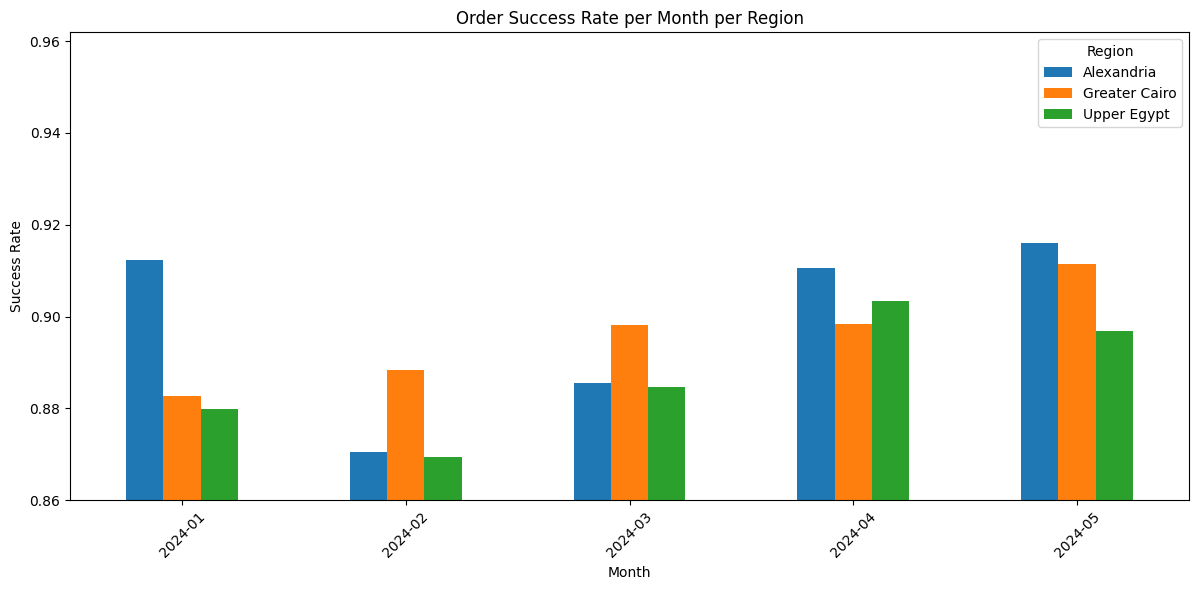

In [ ]:
success_rate_per_month_region = success_rate_per_month_region.reset_index()
success_rate_per_month_region.columns = ['Month', 'Region', 'Success Rate']
pivot_data = success_rate_per_month_region.pivot(index='Month', columns='Region', values='Success Rate')

# Plotting
plt.figure(figsize=(12, 6))
pivot_data.plot(kind='bar', ax=plt.gca())
plt.title('Order Success Rate per Month per Region')
plt.xlabel('Month')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.legend(title='Region')

plt.tight_layout()
plt.ylim(bottom=0.86) # started with 0.8 instead of zero to better visualize the difference
plt.show()

How to improve these sucess rate ?
Need to investigate the reasons for the failures for example Success rate maybe low in upper egypt due to shipping time, or the quality for which the product arrive.
Implement customer feedback loop to improve these regions will help in customing a more accurate solution once spotted the reasons


## Delayed Orders

      Month         Region  Delayed Orders
0   2024-01     Alexandria             874
1   2024-01  Greater Cairo           16977
2   2024-01    Upper Egypt            6562
3   2024-02     Alexandria            1847
4   2024-02  Greater Cairo            4416
5   2024-02    Upper Egypt            2248
6   2024-03     Alexandria             888
7   2024-03  Greater Cairo            2633
8   2024-03    Upper Egypt            1013
9   2024-04     Alexandria             823
10  2024-04  Greater Cairo            6057
11  2024-04    Upper Egypt            1523
12  2024-05     Alexandria             585
13  2024-05  Greater Cairo            4246
14  2024-05    Upper Egypt            1265


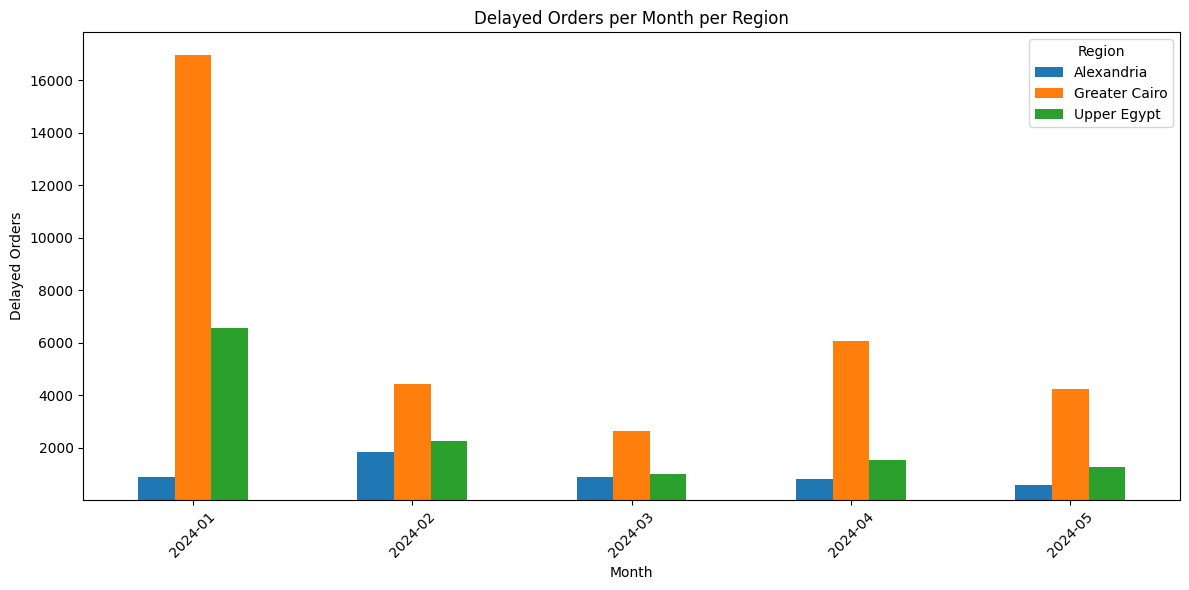

In [ ]:
df_dataset1['Created'] = pd.to_datetime(df_dataset1['Created'])
df_dataset1['Delivered'] = pd.to_datetime(df_dataset1['Delivered'])
df_dataset1['Expected_Delivery'] = df_dataset1['Created'] + pd.Timedelta(days=2)
delayed_orders = df_dataset1[df_dataset1['Delivered'] > df_dataset1['Expected_Delivery']]
delayed_orders_per_month_region = delayed_orders.groupby(['Month', 'Region']).size().reset_index(name='Delayed Orders')
print(delayed_orders_per_month_region)
pivot_data = delayed_orders_per_month_region.pivot(index='Month', columns='Region', values='Delayed Orders')


# Plotting
plt.figure(figsize=(12, 6))
pivot_data.plot(kind='bar', ax=plt.gca())
plt.title('Delayed Orders per Month per Region')
plt.xlabel('Month')
plt.ylabel('Delayed Orders')
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()
plt.ylim(bottom=0.86) # started with 0.86 instead of zero to better visualize the difference
plt.show()

## Churn Analysis

assuming that churn is customers who did not place any orders during a specific month after placing orders in the previous month.
Churn rate is calculated as the proportion of customers who did not place orders in the current month compared to the previous month. This is represented as

Churn Rate = 1 − (Customers in Current Month / Customers in Previous Month)
​


In [ ]:
customers_per_month = df_dataset1.groupby('Month')['Retailer ID'].nunique()
churn_rate_feb = 1 - (customers_per_month['2024-02'] / customers_per_month['2024-01'])
churn_rate_mar = 1 - (customers_per_month['2024-03'] / customers_per_month['2024-02'])
churn_rate_apr = 1 - (customers_per_month['2024-04'] / customers_per_month['2024-03'])

print(f"Churn Rate for February: {churn_rate_feb:.2%}")
print(f"Churn Rate for March: {churn_rate_mar:.2%}")
print(f"Churn Rate for April: {churn_rate_apr:.2%}")

Churn Rate for February: 1.30%
Churn Rate for March: 8.97%
Churn Rate for April: 5.09%


The churn rates displayed—1.30% for February, 8.97% for March, and 5.09% for April—reflect the proportion of customers who did not make purchases in the subsequent month after initially making purchases. A lower churn rate indicates higher customer retention, with February retaining 98.70% of January's customers, March retaining 91.03% of February's customers, and April retaining 94.91% of March's customers. Higher churn rates, such as in March, suggest a greater number of customers ceased purchasing compared to lower rates in February and April

We can create a correlation diagram between the churned customer and there success rate and late delivery. these diagram may give an indicator how strong does these metrics affect the churn rate

# Dataset 2

## Data Exploration

In [ ]:
df_dataset2 = pd.read_excel("Dataset 2 Final.xlsx")
df_dataset2.head()

,order creation,PARENT_SALES_ORDER_ID,category,product_id,sku,sales,order status
0,2024-05-03,6924753,صلصة و صوص,7558,مايونيز دوى باك أسكويزي- 285 جم,269.32,delivered
1,2024-05-01,6929347,صابون,2438,جوي صابون عرض خاص - 120 جم,61.25,delivered
2,2024-05-02,6929489,طحينة,590,البوادي طحينة- 250 جم,168.00,delivered
3,2024-05-01,6929729,حاجه ساقعه,1504,كوكاكولا+ 0.5 لتر - 1.45 لتر,273.00,delivered
4,2024-05-01,6929781,شوكولاتة,5644,شوكولاتة كادبوري بابلي سادة - 87 جرام,473.02,Failed


In [ ]:
df_dataset2.info() # no null values found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214524 entries, 0 to 214523
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order creation         214524 non-null  datetime64[ns]
 1   PARENT_SALES_ORDER_ID  214524 non-null  int64         
 2   category               214524 non-null  object        
 3   product_id             214524 non-null  int64         
 4   sku                    214524 non-null  object        
 5   sales                  214524 non-null  float64       
 6   order status           214524 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 11.5+ MB


Check the timeframe of the dataset

In [ ]:
timeframe_start = df_dataset2['order creation'].min()
timeframe_end = df_dataset2['order creation'].max()

timeframe_start, timeframe_end

unique_categories = df_dataset2['category'].unique()
print("Unique categories:", unique_categories)

Unique categories: ['صلصة و صوص' 'صابون' 'طحينة' 'حاجه ساقعه' 'شوكولاتة' 'مرقة وخلطات' 'قهوة'
 'منظفات' 'معلبات' 'كيك وكرواسون' 'جبنة موتزاريلا' 'ورقيات'
 'شامبو و شاور جيل' 'ألبان' 'جبن' 'سائل أطباق' 'حفاضات أطفال'
 'بقوليات و حبوب سايب' 'الفوط الصحية' 'عصاير' 'سكر' 'بسكويت و معمول' 'شاي'
 'شعرية سريعة التحضير' 'أرز' 'حلاوة طحينية' 'زيوت' 'مشروبات الطاقة' 'عسل'
 'مجمدات دجاج' 'اعشاب' 'مكرونة' 'مكرونة سايب' 'كريم و جل للشعر'
 'حلويات و لبان' 'ويفر' 'خضار مجمد' 'حلويات سريعة التحضير' 'جبن سايب'
 'بقوليات' 'توابل وبهارات' 'مجمدات لحوم' 'دقيق' 'بطاريات ولمبات'
 'لانشون ثلاجة' 'خل' 'كاكاو و مبيضات' 'أدوات حلاقة' 'زبدة' 'مربي'
 'لانشون جاف' 'تونة و سمك' 'سمنة' 'مزيل عرق' 'دقيق سايب' 'خلطات سايب'
 'ارز سايب' 'كروت شحن' 'سمنة سايب' 'بهارات سايب' 'كبريت واكياس بلاستيك'
 'معجنات' 'مطهرات و ملمعات' 'زيت سايب' 'زبادي و بودينج' 'مبيدات حشرية'
 'معجون أسنان']


## Weekly Sales Trend

In [ ]:
df_dataset2['order creation'] = pd.to_datetime(df_dataset2['order creation'])

df_dataset2_delivered = df_dataset2[df_dataset2['order status'] == 'delivered']

def get_week(date):
    if date.day <= 7:
        return 'Week 1'
    elif date.day <= 14:
        return 'Week 2'
    elif date.day <= 21:
        return 'Week 3'
    else:
        return 'Week 4'

# df_dataset2_delivered['Week'] = df_dataset2_delivered['order creation'].dt.week
df_dataset2_delivered['Month'] = df_dataset2_delivered['order creation'].dt.month_name()
df_dataset2_delivered['Week'] = df_dataset2_delivered['order creation'].apply(get_week) + " - " + df_dataset2_delivered['Month']

weekly_sales = df_dataset2_delivered.groupby('Week')['sales'].sum()

weekly_sales

/var/folders/cl/z_v777rd4mndgt2ypckwzb_m0000gn/T/ipykernel_3431/1612242199.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset2_delivered['Month'] = df_dataset2_delivered['order creation'].dt.month_name()
/var/folders/cl/z_v777rd4mndgt2ypckwzb_m0000gn/T/ipykernel_3431/1612242199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset2_delivered['Week'] = df_dataset2_delivered['order creation'].apply(get_week) + " - " + df_dataset2_delivered['Month']


Week
Week 1 - May   10658617.62
Week 2 - May   13511796.13
Week 3 - May    4227379.14
Week 4 - May   15570828.35
Name: sales, dtype: float64

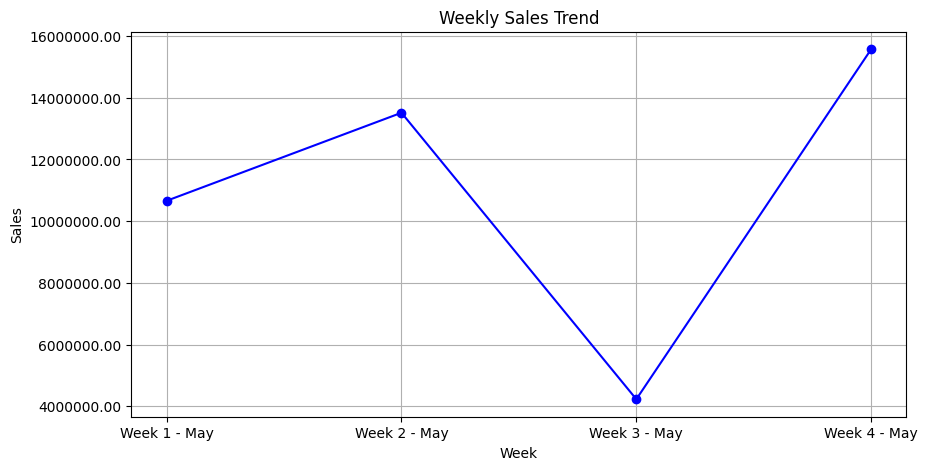

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(weekly_sales.index, weekly_sales.values, marker='o', linestyle='-', color='b')
ax.set_title('Weekly Sales Trend')
ax.set_xlabel('Week')
ax.set_ylabel('Sales')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
ax.grid(True)
plt.show()

week 3 of may is the lowest week of sales, reasons for the drop could be the number of failed orders, or the decrease of specific category

# Dataset 3

## Data Exploration

In [ ]:
df_sheet1 = pd.read_excel("Dataset 3 Final.xlsx", 1 )
df_sheet2 = pd.read_excel("Dataset 3 Final.xlsx", 1 )
df_sheet2.head()

,Month,Category,Brand,Sales
0,Jan,juice,Coool,75035.00
1,March,juice,Fruty,56296.00
2,Feb,juice,Kol Youm,1787830.35
3,Feb,juice,Rani,1122939.88
4,March,juice,Best,478871.12


In [ ]:
unique_categories = df_sheet1['Category'].unique()
unique_brand = df_sheet1['Brand'].unique()
print("Unique categories:", unique_categories)
print("Unique brands:", unique_brand)

Unique categories: ['juice']
Unique brands: ['Coool' 'Fruty' 'Kol Youm' 'Rani' 'Best' 'Tang' 'Juhayna Juice' 'SunTop'
 'Viva' 'Bkhiro' 'Roots' 'Aslan' 'Beyti Juices' 'Bashair' 'Vitrac'
 'Domti Juice' 'Obour land' 'Lamar Juice']


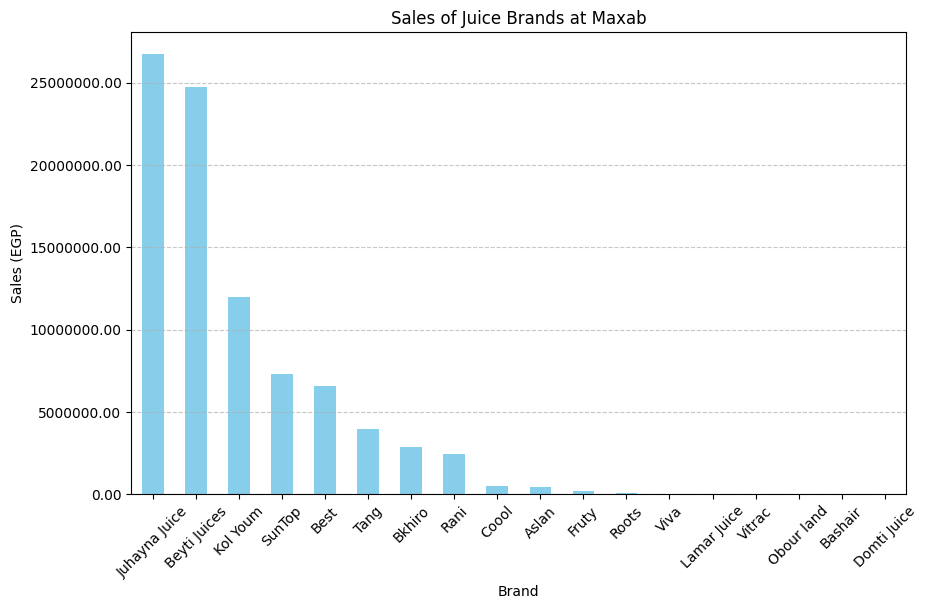

In [ ]:
brand_sales = df_sheet2.groupby('Brand')['Sales'].sum().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
brand_sales.plot(kind='bar', color='skyblue', ax=ax)
ax.set_title('Sales of Juice Brands at Maxab')
ax.set_xlabel('Brand')
ax.set_ylabel('Sales (EGP)')
ax.set_xticklabels(brand_sales.index, rotation=45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

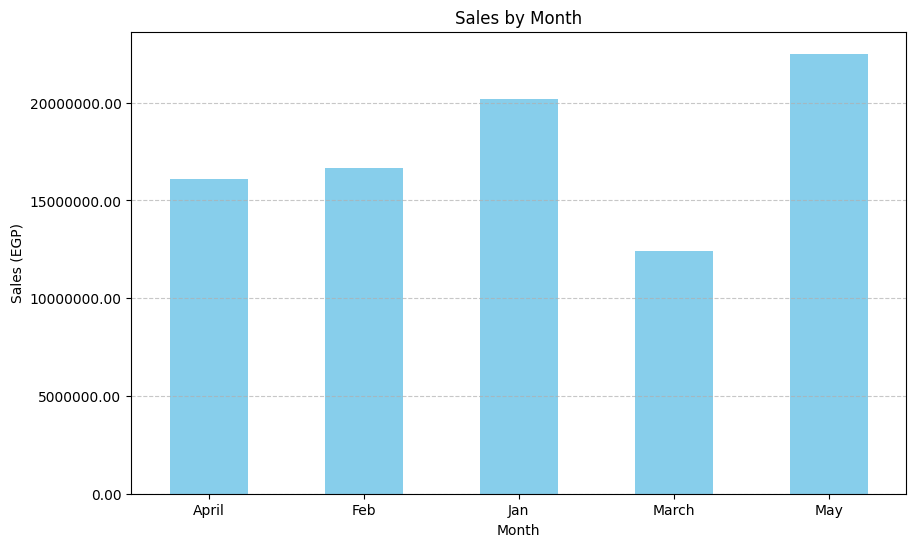

In [ ]:
sales_by_month = df_sheet2.groupby('Month')['Sales'].sum()
fig, ax = plt.subplots(figsize=(10, 6))
sales_by_month.plot(kind='bar', color='skyblue', ax=ax)
ax.set_title('Sales by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Sales (EGP)')
ax.set_xticklabels(sales_by_month.index, rotation=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


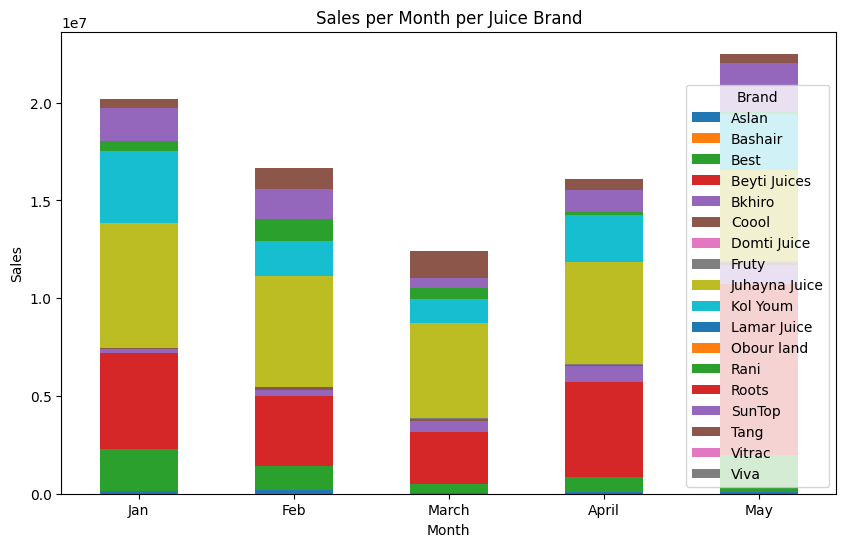

In [ ]:
df_pivot = df_sheet2.pivot_table(index='Month', columns='Brand', values='Sales', aggfunc='sum', fill_value=0)

# Sort months in a logical order
month_order = ['Jan', 'Feb', 'March','April','May']
df_pivot = df_pivot.reindex(month_order)
fig, ax = plt.subplots(figsize=(10, 6))
df_pivot.plot(kind='bar', stacked=True, ax=ax)

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales per Month per Juice Brand')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Brand')
plt.show()

Conclusion: Beyti sales increased in may causing the overall to increase